# Pràctica 2


In [1]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import scipy.stats

# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset_test = load_dataset('test.csv')
dataset_train = load_dataset('train.csv')

data_train = dataset_train.values
data_test = dataset_test.values

print("Dimensionalitat de la BBDD Train:", dataset_train.shape)
print("Dimensionalitat de la BBDD Test:", dataset_test.shape)



Dimensionalitat de la BBDD Train: (2000, 21)
Dimensionalitat de la BBDD Test: (1000, 21)


# Apartat (B): Classificació Numèrica (6pts)

Per a aquest primer apartat, s'analitzarà els tipus d'atributs que es tenen i, si no està estipulat, **caldrà fixar quin és l'atribut objectiu a classificar de tots els que hi ha a la base de dades**.

Durant els següents apartats, es recomana anar fent una taula amb el mètode, paràmetres i precisió obtinguda. D'aquesta manera serà més fàcil entendre i valorar què s'aconsegueix en cada metode.

### 1. EDA (exploratory data analysis)

Exploració i visualització de la base de dades assignada.

In [2]:
dataset_train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [3]:
print("Per comptar el nombre de valors no existents:")
dataset_train.info()

Per comptar el nombre de valors no existents:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_

Observem que, tot i no haver nulls a la base de dades, es troben coses sense sentit com sc_w = 0; comptem quants 0 hi ha als atributs no binaris per decidir si tenen sentit o no.

In [4]:
for i in dataset_train:
    a = dataset_train[i][dataset_train[i]==0].count()
    b = len(dataset_train[i].unique())
    if (b != 2 and a > 0):
        print(i, b, a)

fc 20 474
pc 21 101
px_height 1137 2
sc_w 19 180
price_range 4 500


In [5]:
for i in dataset_test:
    a = dataset_test[i][dataset_test[i]==0].count()
    b = len(dataset_test[i].unique())
    if (b != 2 and a > 0):
        print(i, b, a)

fc 20 210
pc 21 40
px_height 694 2
sc_w 19 112


Trobem que les columnes sc_w i px_height tenen valors 0 que no tenen sentit. Per decidir com tractar-los i estudiar les relacions entre els atributs fem la correlació.

In [6]:
correlacio = dataset_train.corr()
correlacio["price_range"]

battery_power    0.200723
blue             0.020573
clock_speed     -0.006606
dual_sim         0.017444
fc               0.021998
four_g           0.014772
int_memory       0.044435
m_dep            0.000853
mobile_wt       -0.030302
n_cores          0.004399
pc               0.033599
px_height        0.148858
px_width         0.165818
ram              0.917046
sc_h             0.022986
sc_w             0.038711
talk_time        0.021859
three_g          0.023611
touch_screen    -0.030411
wifi             0.018785
price_range      1.000000
Name: price_range, dtype: float64

In [7]:
import seaborn as sns
correlacio = dataset_train.corr()
dic = {}

for i in correlacio:
    dic[i] = -1
    for j in correlacio[i]:
        if abs(j) > 0.2:
            dic[i] += 1
print(dic)

{'battery_power': 1, 'blue': 0, 'clock_speed': 0, 'dual_sim': 0, 'fc': 1, 'four_g': 1, 'int_memory': 0, 'm_dep': 0, 'mobile_wt': 0, 'n_cores': 0, 'pc': 1, 'px_height': 1, 'px_width': 1, 'ram': 1, 'sc_h': 1, 'sc_w': 1, 'talk_time': 0, 'three_g': 1, 'touch_screen': 0, 'wifi': 0, 'price_range': 2}


Decidim quedar-nos amb les correlacions superiors a 0.2.

In [8]:
l = []

s = "price_range"

for i in range(len(correlacio[s])):
    if abs(correlacio[s][i]) > 0.2 and correlacio[s][i] != 1:
        l.append(i)
print(correlacio[s][l])

battery_power    0.200723
ram              0.917046
Name: price_range, dtype: float64


In [9]:
names_cor = [s]
for i in l:
    names_cor.append(dataset_train.columns.tolist()[i])
print(names_cor)

['price_range', 'battery_power', 'ram']


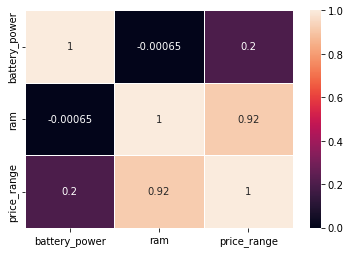

In [10]:
dataset_cor = dataset_train.copy()

for i in dataset_train:
    if i not in names_cor:
        dataset_cor = dataset_cor.drop(i, axis = 1)

correlacio = dataset_cor.corr() 

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

Es generen a continuació histogrames per estudiar millor els atributs i observar si segueixen alguna distribució en concret.

C:\Users\andre\AppData\Local\Temp\ipykernel_27320\3147709651.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


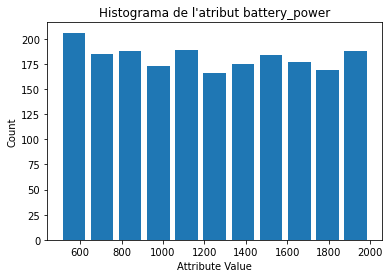

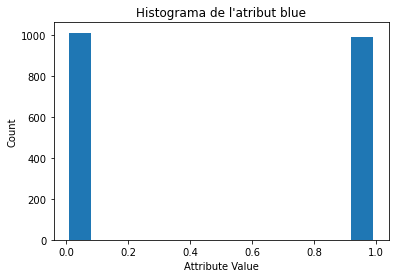

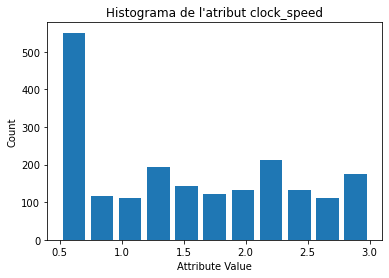

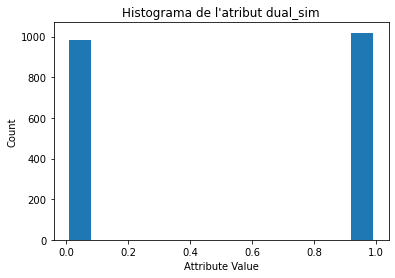

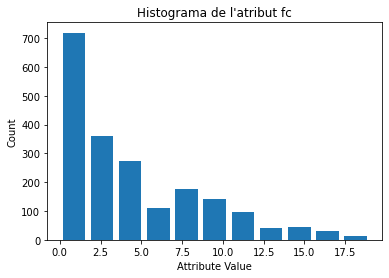

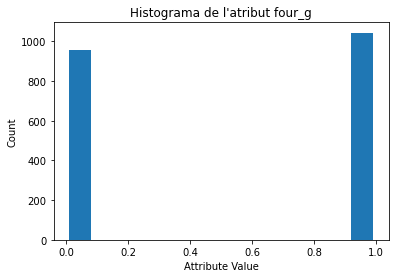

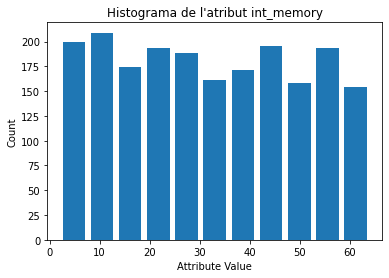

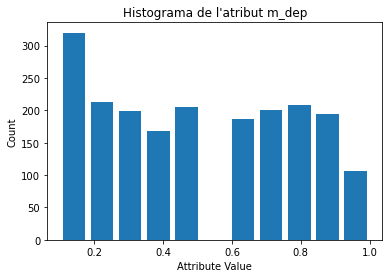

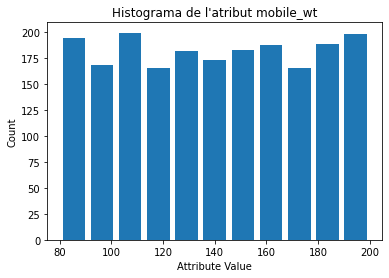

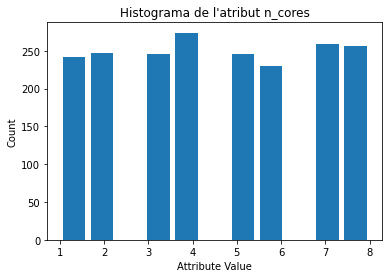

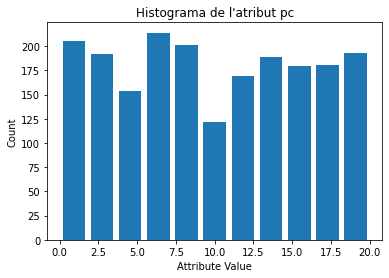

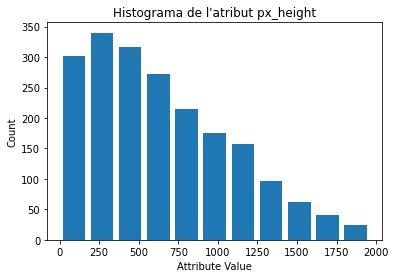

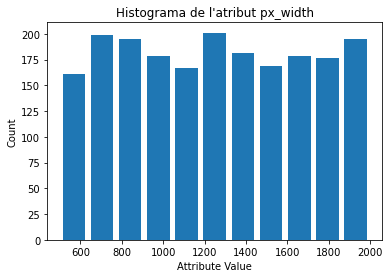

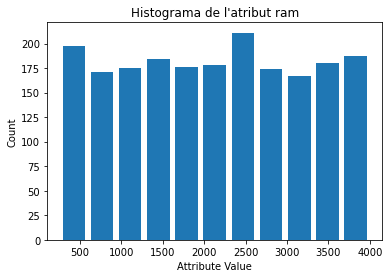

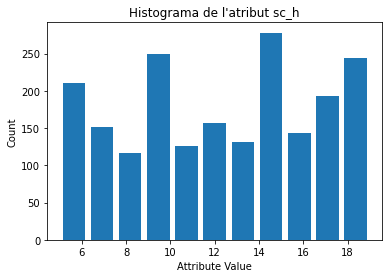

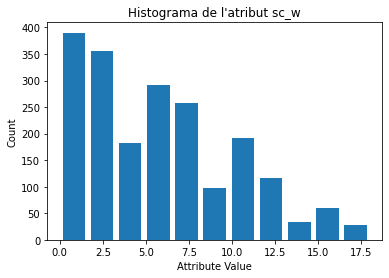

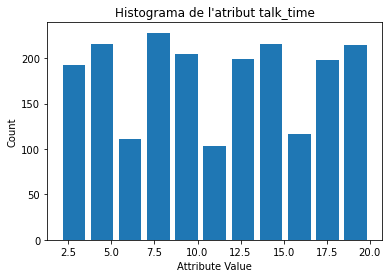

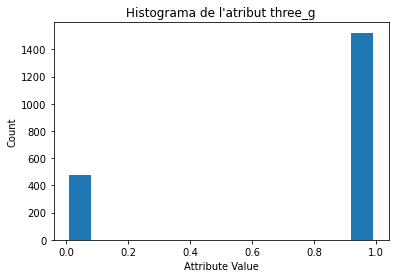

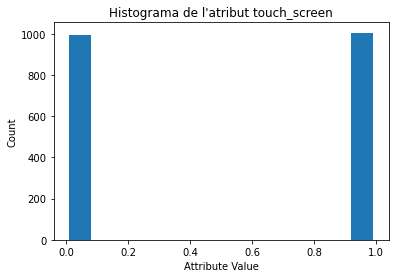

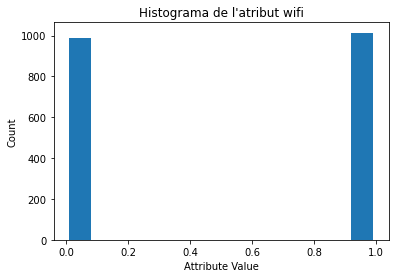

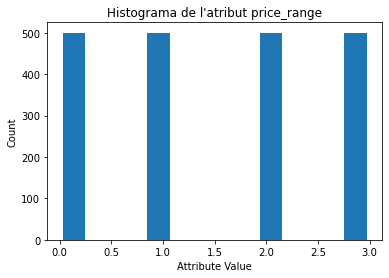

In [11]:
for i in dataset_train:
    X = dataset_train[i].values
    plt.figure()
    plt.title("Histograma de l'atribut "+str(i))
    plt.xlabel("Attribute Value")
    plt.ylabel("Count")
    hist = plt.hist(X, bins=11, range=[np.min(X), np.max(X)], histtype="bar", rwidth=0.8)
    plt.plot()

Generem scatter plots per estudiar millor la relació entre els diversos atributs de la base de dades i el nostre objectiu; price_range.

C:\Users\andre\AppData\Local\Temp\ipykernel_27320\2747340479.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


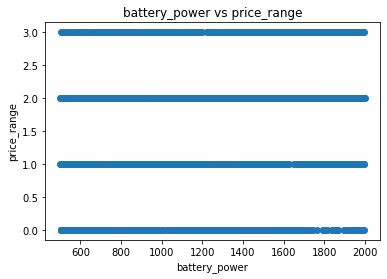

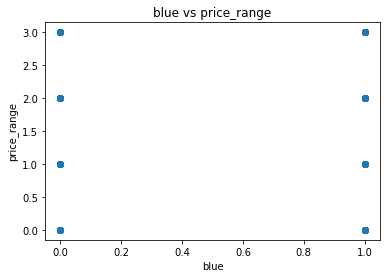

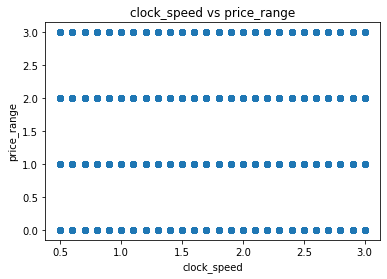

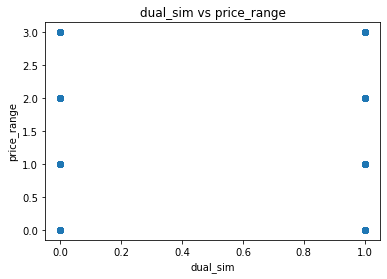

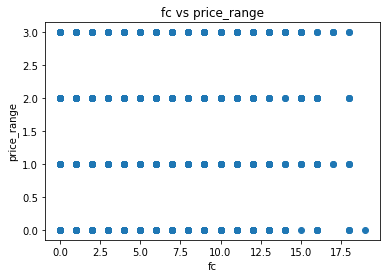

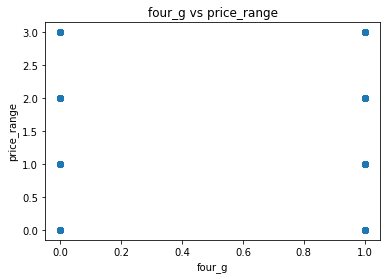

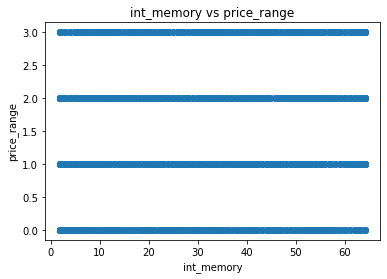

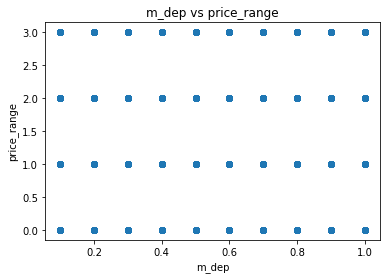

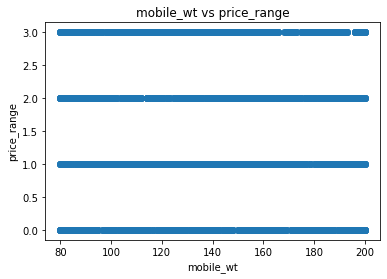

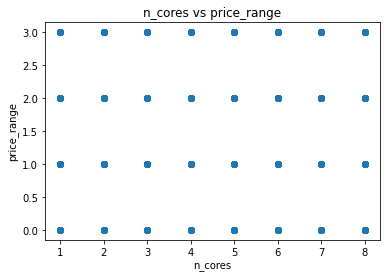

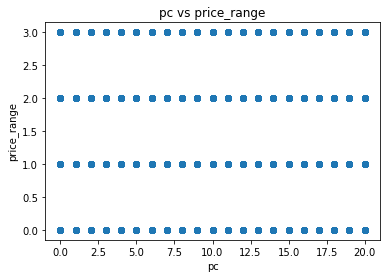

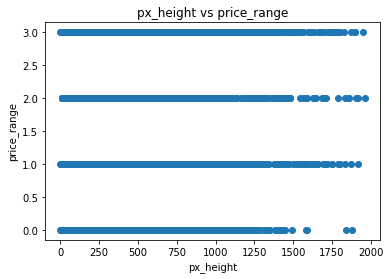

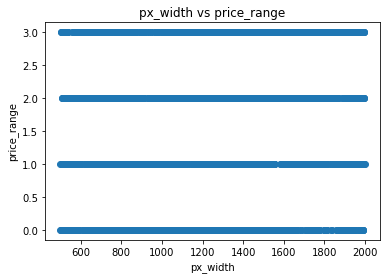

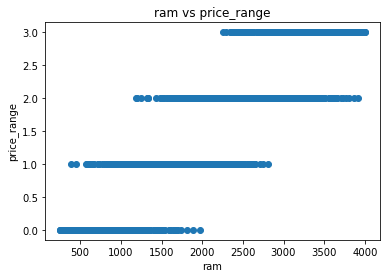

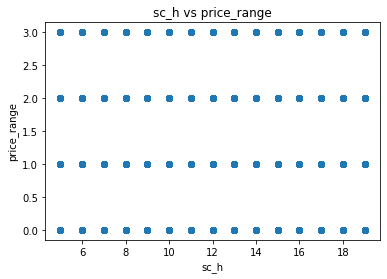

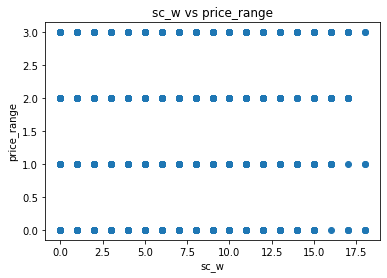

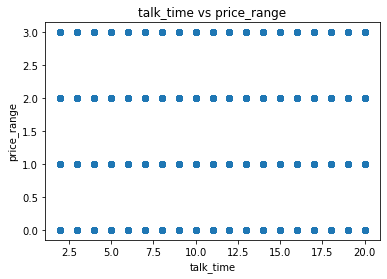

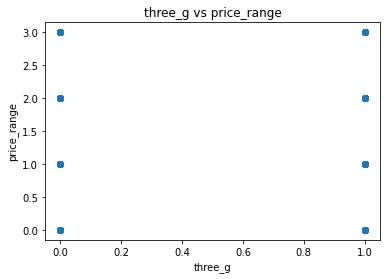

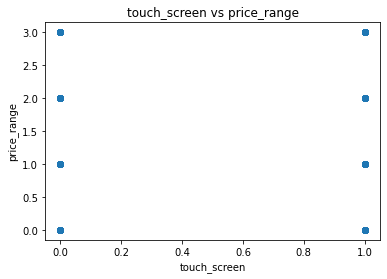

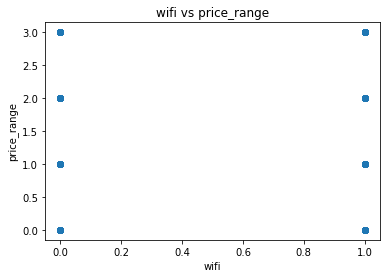

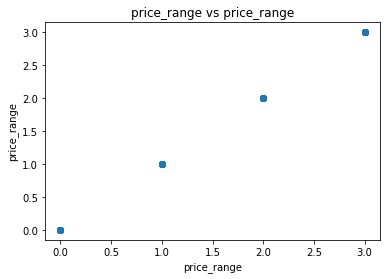

In [12]:
Y = dataset_train[s].values
for i in dataset_train:
    X = dataset_train[i].values
    plt.figure()
    plt.title(str(i) + " vs " + s)
    plt.xlabel(str(i))
    plt.ylabel(s)
    plt.scatter(X, Y)
    

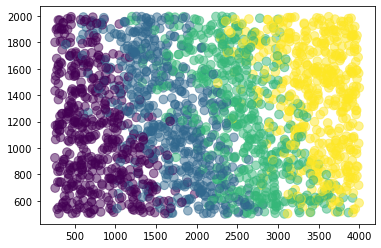

In [13]:
plt.scatter(dataset_train["ram"].values, dataset_train["battery_power"].values, s=75, c=Y, alpha=.5)

### 2. Preprocessing (normalitzation, outlier removal, feature selection..)

Es repeteix el procès anterior amb el dataset estandaritzat.

In [15]:
def standarize(X):
    mean = X.mean(0)
    std = X.std(0)
    x = X - mean
    x /= std
    return x

dt = dataset_train.copy()

for i in dt:
    dt[i] = standarize(dataset_train[i])

In [16]:
import seaborn as sns
correlacio = dt.corr()
dic = {}

for i in correlacio:
    dic[i] = -1
    for j in correlacio[i]:
        if abs(j) > 0.2:
            dic[i] += 1
print(dic)

{'battery_power': 1, 'blue': 0, 'clock_speed': 0, 'dual_sim': 0, 'fc': 1, 'four_g': 1, 'int_memory': 0, 'm_dep': 0, 'mobile_wt': 0, 'n_cores': 0, 'pc': 1, 'px_height': 1, 'px_width': 1, 'ram': 1, 'sc_h': 1, 'sc_w': 1, 'talk_time': 0, 'three_g': 1, 'touch_screen': 0, 'wifi': 0, 'price_range': 2}


In [17]:
l = []

s = "price_range"

for i in range(len(correlacio[s])):
    if abs(correlacio[s][i]) > 0.2 and correlacio[s][i] != 1:
        l.append(i)
print(correlacio[s][l])

battery_power    0.200723
ram              0.917046
Name: price_range, dtype: float64


In [18]:
names_cor = [s]
for i in l:
    names_cor.append(dt.columns.tolist()[i])
print(names_cor)

['price_range', 'battery_power', 'ram']


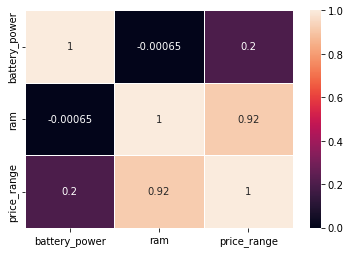

In [19]:
dataset_cor = dt.copy()

for i in dataset_train:
    if i not in names_cor:
        dataset_cor = dataset_cor.drop(i, axis = 1)

correlacio = dataset_cor.corr() 

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

C:\Users\andre\AppData\Local\Temp\ipykernel_27320\2039397843.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


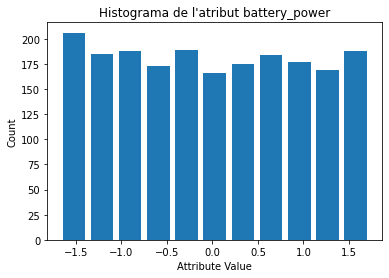

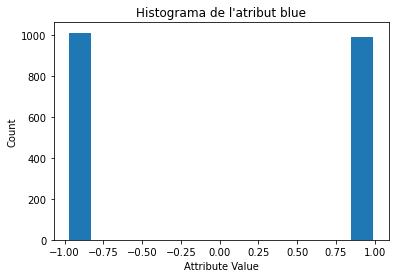

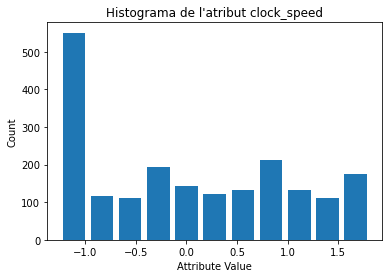

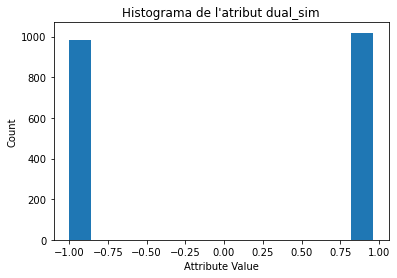

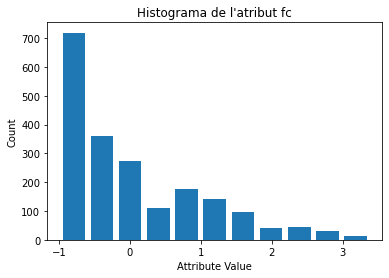

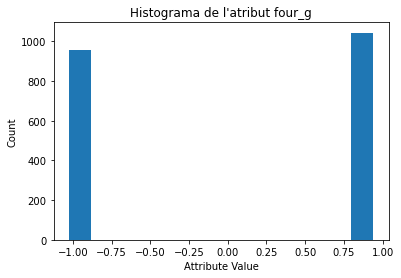

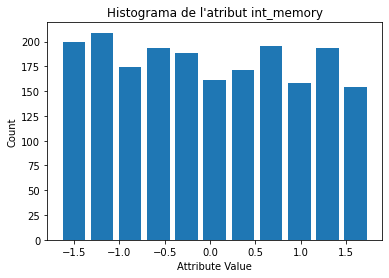

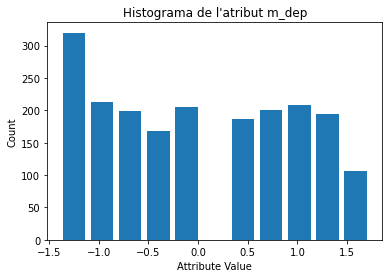

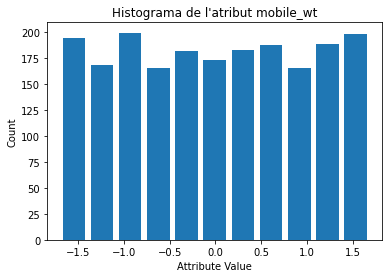

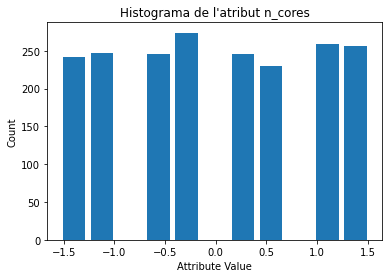

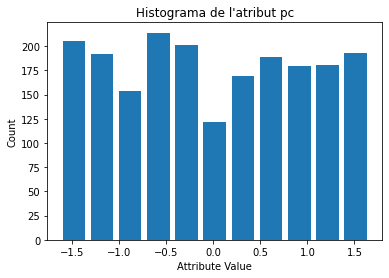

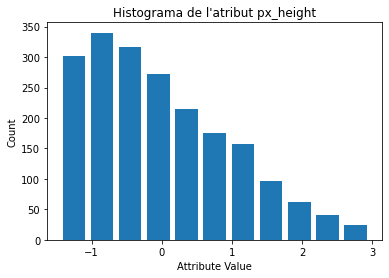

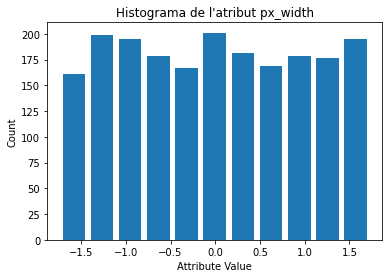

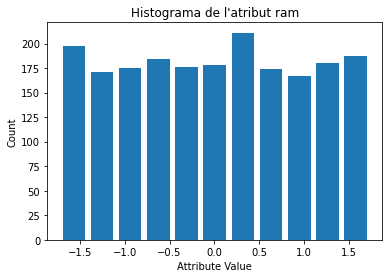

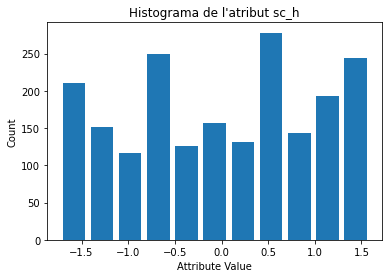

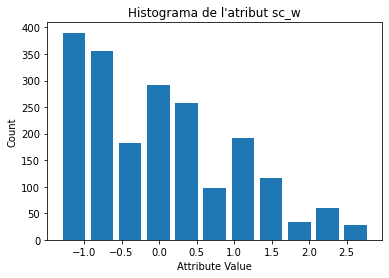

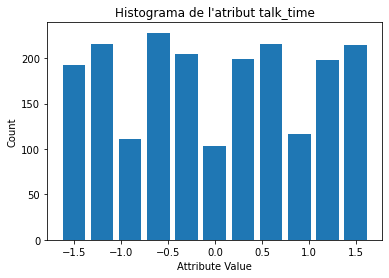

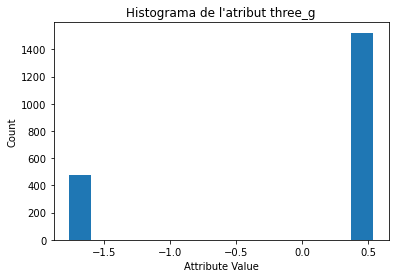

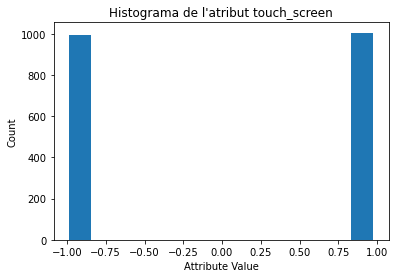

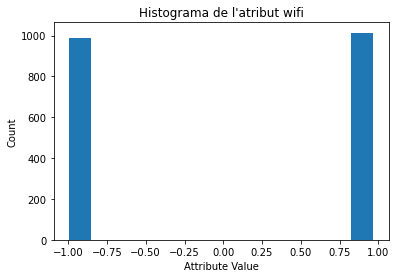

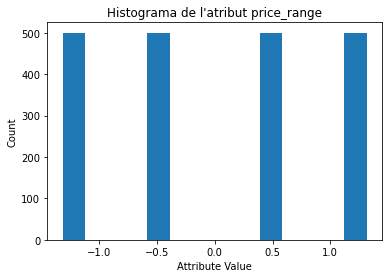

In [20]:
for i in dataset_train:
    X = dt[i].values
    plt.figure()
    plt.title("Histograma de l'atribut "+str(i))
    plt.xlabel("Attribute Value")
    plt.ylabel("Count")
    hist = plt.hist(X, bins=11, range=[np.min(X), np.max(X)], histtype="bar", rwidth=0.8)
    plt.plot()

C:\Users\andre\AppData\Local\Temp\ipykernel_27320\3351359654.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


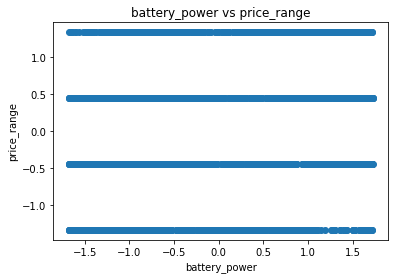

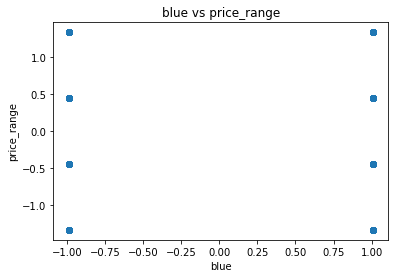

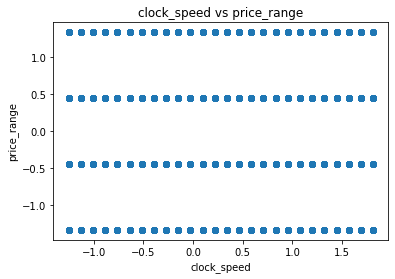

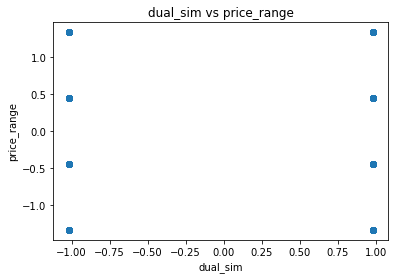

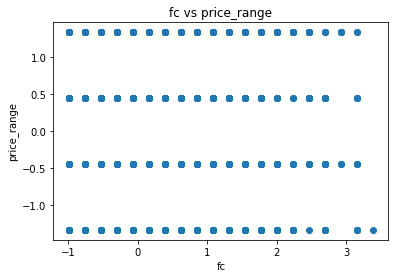

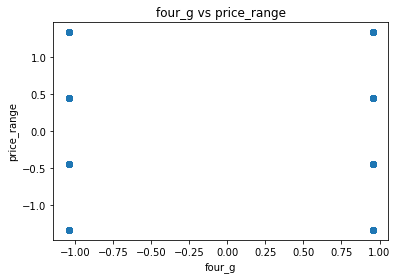

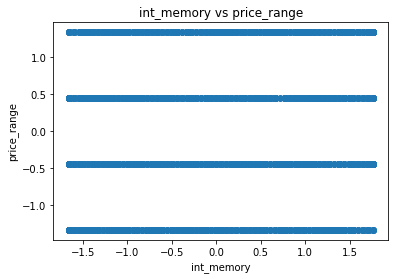

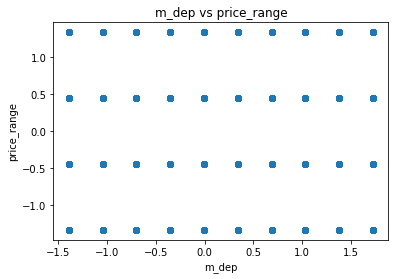

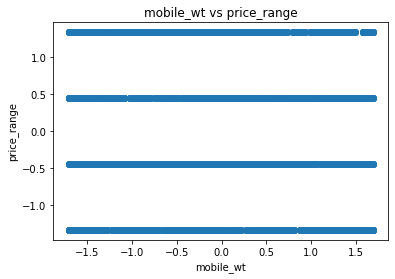

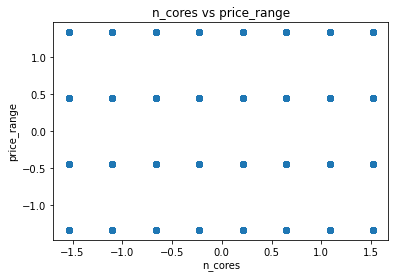

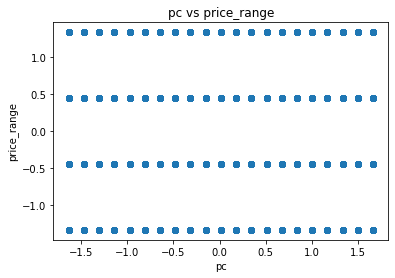

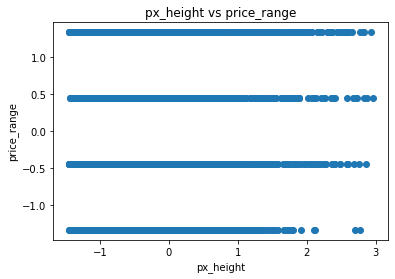

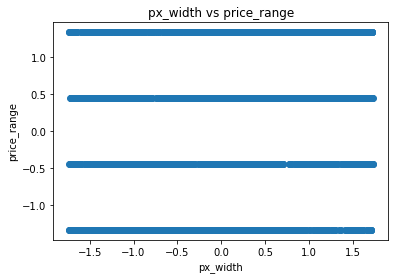

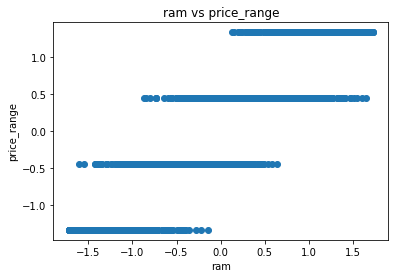

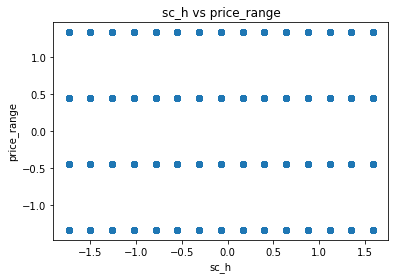

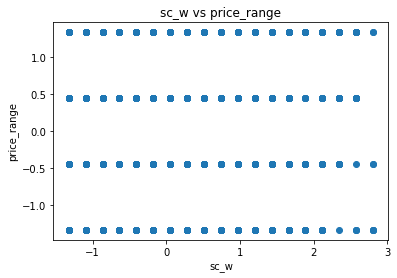

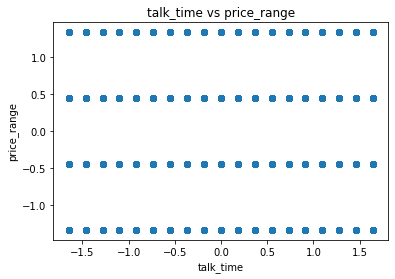

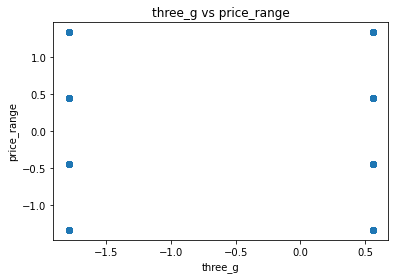

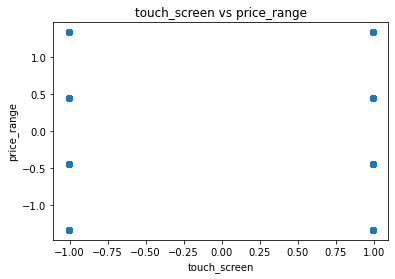

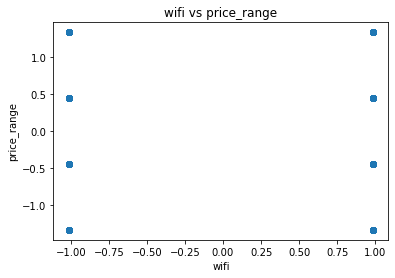

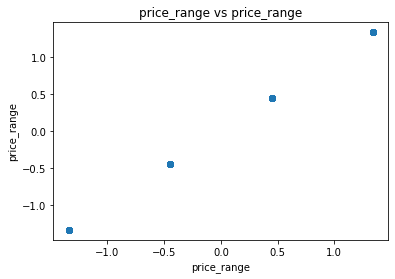

In [21]:
Y = dt[s].values
for i in dataset_train:
    X = dt[i].values
    plt.figure()
    plt.title(str(i) + " vs " + s)
    plt.xlabel(str(i))
    plt.ylabel(s)
    plt.scatter(X, Y)
    

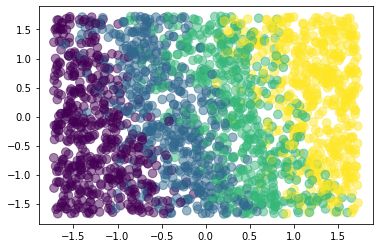

In [22]:
plt.scatter(dt["ram"].values, dt["battery_power"].values, s=75, c=Y, alpha=.5)

Veiem que la normalització de les dades no afecta, pel que no es treballarà amb el dataset normalitzat.

### 3. Model Selection
-Logistic Regression

-DecisionTree Classifier

-RandomForest Classifier

-KNeighborsClassifier

-AdaBoost Classifier

-SVC

-KMeans

-GaussianMixture

mostrem les confusion matrix de cadascún dels models juntament amb la seva accuracy per posteriorment escolllir-ne el millor (latex apartat 4)

0.8255


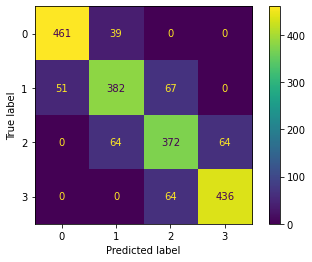

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)
clf = LogisticRegression(random_state=0)
clf.fit(X, y)
print(clf.score(X,y))

yp = clf.predict(X)
cm = confusion_matrix(y,yp, labels = clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()


0.8405


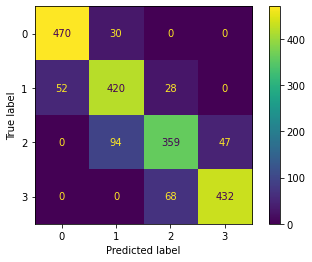

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_validate

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)
clf = DecisionTreeClassifier(random_state = 0, max_depth = 5)
clf.fit(X, y)

yp = clf.predict(X)
cm = confusion_matrix(y,yp, labels = clf.classes_)
acc = 0
for i in range(len(cm)):
    acc += cm[i][i]
acc/= len(y)

print(acc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

0.849


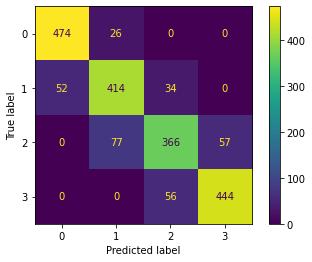

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_validate

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

clf = RandomForestClassifier(random_state = 0, max_depth = 5)
clf.fit(X, y)
 
yp = clf.predict(X)
cm = confusion_matrix(y,yp, labels = clf.classes_)
acc = 0
for i in range(len(cm)):
    acc += cm[i][i]
acc/= len(y)

print(acc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

0.8435


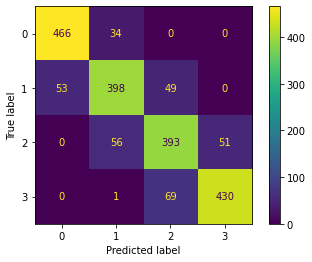

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

clf = KNeighborsClassifier(5)
clf.fit(X, y)

yp = clf.predict(X)
cm = confusion_matrix(y,yp, labels = clf.classes_)
acc = 0
for i in range(len(cm)):
    acc += cm[i][i]
acc/= len(y)

print(acc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.6575


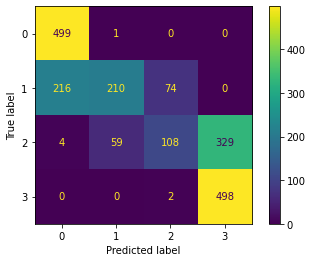

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

logi = LogisticRegression()
clf = AdaBoostClassifier(base_estimator= logi ,n_estimators=100)
clf.fit(X,y)


yp = clf.predict(X)
cm = confusion_matrix(y,yp, labels = clf.classes_)
acc = 0
for i in range(len(cm)):
    acc += cm[i][i]
acc/= len(y)

print(acc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

0.826


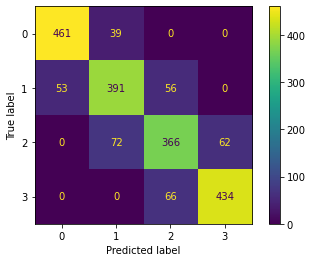

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)
clf.predict(X)

yp = clf.predict(X)
cm = confusion_matrix(y,yp, labels = clf.classes_)
acc = 0
for i in range(len(cm)):
    acc += cm[i][i]
acc/= len(y)

print(acc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=4, random_state=0).fit(X)

yp = clf.predict(X)
cm = confusion_matrix(y,yp, labels = clf.labels_)
acc = 0
for i in range(len(cm)):
    acc += cm[i][i]
acc/= len(y)

print(acc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
disp.plot()
plt.show()

0.0715


In [ ]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=4, random_state=0).fit(X)
gm.means_
yp = gm.predict(X)

cm = confusion_matrix(y,yp, labels = [0,1,2,3])
acc = 0
for i in range(len(cm)):
    acc += cm[i][i]
acc/= len(y)

print(acc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
disp.plot()
plt.show()

### 4. Crossvalidation
Un cop seleccionats quins models es volen testejar sobre les dades, es cros-validen els resultats per poder-se evaluar correctament.

-Logistic Regression

-DecisionTree Classifier

-RandomForest Classifier

-KNeighborsClassifier

-AdaBoost Classifier

-SVC

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(base_estimator= logi, n_estimators=100)
clf.fit(X,y)
scores = cross_val_score(clf, X, y, cv=5)
print(scores.mean())

yp = clf.predict(X)
cm = confusion_matrix(y,yp, labels = clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)
clf = LogisticRegressionCV(cv = 5, random_state=0)
clf.fit(X, y)
print(clf.score(X,y))

yp = clf.predict(X)
cm = confusion_matrix(y,yp, labels = clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_validate

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

clf = RandomForestClassifier(random_state = 0, max_depth = 5)
clf.fit(X,y)
print(np.mean(cross_validate(clf, X, y, cv=10, scoring='accuracy')["test_score"]))
print(cross_validate(clf, X, y, cv=10, scoring='accuracy')["test_score"])

yp = clf.predict(X)
cm = confusion_matrix(y,yp, labels = clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_validate

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)
clf = DecisionTreeClassifier(random_state = 0, max_depth = 5)
clf.fit(X, y)
print(np.mean(cross_validate(clf, X, y, cv=5, scoring='accuracy')["test_score"]))
yp = clf.predict(X)
cm = confusion_matrix(y,yp, labels = clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

clf = KNeighborsClassifier(5)
clf.fit(X, y)
print(np.mean(cross_validate(clf, X, y, cv=5, scoring='accuracy')["test_score"]))

yp = clf.predict(X)
cm = confusion_matrix(y,yp, labels = clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_validate

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)
print(np.mean(cross_validate(clf, X, y, cv=5, scoring='accuracy')["test_score"]))
yp = clf.predict(X)
cm = confusion_matrix(y,yp, labels = clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

### 5. Metric Analysis

El mòdul sklearn.metrics implementa diverses funcions per mesurar el rendiment de la classificació. Algunes mètriques poden requerir estimacions de probabilitat de la classe positiva, valors de confiança o valors de decisions binaris. La majoria de les implementacions permeten que cada mostra proporcioni una contribució ponderada a la puntuació global, mitjançant el paràmetre sample_weight.

Així doncs, com les classes del nostre dataset són equiprobables, usarem el mètode de l'accuracy.

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Compute Precision-Recall and plot curve
precision = {}
recall = {}
average_precision = {}
plt.figure()

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

part = 0.8
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf.fit(x_t, y_t)
probs = clf.predict_proba(x_v)
y_p = clf.predict(x_v)
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_v, y_p, target_names=target_names))

print ("Correct classification SVM ", part, "% of the data: ", clf.score(x_v, y_v))

for i in range(4):
    l = [ j == i for j in y_v]
    precision[i], recall[i], _ = precision_recall_curve(l, probs[:, i])
    average_precision[i] = average_precision_score(l, probs[:, i])

    plt.plot(recall[i], precision[i],
    label='Precision-recall curve of class {0} (area = {1:0.2f})'
                           ''.format(i, average_precision[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")

    
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(4):
    l = [ j == i for j in y_v]
    fpr[i], tpr[i], _ = roc_curve(l, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# Plot ROC curve
plt.figure()
for i in range(4):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.legend()

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Compute Precision-Recall and plot curve
precision = {}
recall = {}
average_precision = {}
plt.figure()

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

part = 0.8
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)

clf = KNeighborsClassifier(5)
clf.fit(x_t, y_t)
probs = clf.predict_proba(x_v)
y_p = clf.predict(x_v)
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_v, y_p, target_names=target_names))

print ("Correct classification SVM ", part, "% of the data: ", clf.score(x_v, y_v))

for i in range(4):
    l = [ j == i for j in y_v]
    precision[i], recall[i], _ = precision_recall_curve(l, probs[:, i])
    average_precision[i] = average_precision_score(l, probs[:, i])

    plt.plot(recall[i], precision[i],
    label='Precision-recall curve of class {0} (area = {1:0.2f})'
                           ''.format(i, average_precision[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")

    
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(4):
    l = [ j == i for j in y_v]
    fpr[i], tpr[i], _ = roc_curve(l, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# Plot ROC curve
plt.figure()
for i in range(4):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.legend()

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Compute Precision-Recall and plot curve
precision = {}
recall = {}
average_precision = {}
plt.figure()

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

part = 0.8
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)

clf = DecisionTreeClassifier(random_state = 0, max_depth = 5)
clf.fit(x_t, y_t)
probs = clf.predict_proba(x_v)
y_p = clf.predict(x_v)
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_v, y_p, target_names=target_names))

print ("Correct classification SVM ", part, "% of the data: ", clf.score(x_v, y_v))

for i in range(4):
    l = [ j == i for j in y_v]
    precision[i], recall[i], _ = precision_recall_curve(l, probs[:, i])
    average_precision[i] = average_precision_score(l, probs[:, i])

    plt.plot(recall[i], precision[i],
    label='Precision-recall curve of class {0} (area = {1:0.2f})'
                           ''.format(i, average_precision[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")

    
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(4):
    l = [ j == i for j in y_v]
    fpr[i], tpr[i], _ = roc_curve(l, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# Plot ROC curve
plt.figure()
for i in range(4):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.legend()

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

# Compute Precision-Recall and plot curve
precision = {}
recall = {}
average_precision = {}
plt.figure()

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

part = 0.8
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)

clf = AdaBoostClassifier(base_estimator= logi, n_estimators=100)
clf.fit(x_t, y_t)
probs = clf.predict_proba(x_v)
y_p = clf.predict(x_v)
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_v, y_p, target_names=target_names))

print ("Correct classification SVM ", part, "% of the data: ", clf.score(x_v, y_v))

for i in range(4):
    l = [ j == i for j in y_v]
    precision[i], recall[i], _ = precision_recall_curve(l, probs[:, i])
    average_precision[i] = average_precision_score(l, probs[:, i])

    plt.plot(recall[i], precision[i],
    label='Precision-recall curve of class {0} (area = {1:0.2f})'
                           ''.format(i, average_precision[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")

    
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(4):
    l = [ j == i for j in y_v]
    fpr[i], tpr[i], _ = roc_curve(l, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# Plot ROC curve
plt.figure()
for i in range(4):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.legend()

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Compute Precision-Recall and plot curve
precision = {}
recall = {}
average_precision = {}
plt.figure()

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

part = 0.8
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)

clf = RandomForestClassifier(random_state = 0, max_depth = 5)
clf.fit(x_t, y_t)
probs = clf.predict_proba(x_v)
y_p = clf.predict(x_v)
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_v, y_p, target_names=target_names))

print ("Correct classification SVM ", part, "% of the data: ", clf.score(x_v, y_v))

for i in range(4):
    l = [ j == i for j in y_v]
    precision[i], recall[i], _ = precision_recall_curve(l, probs[:, i])
    average_precision[i] = average_precision_score(l, probs[:, i])

    plt.plot(recall[i], precision[i],
    label='Precision-recall curve of class {0} (area = {1:0.2f})'
                           ''.format(i, average_precision[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")

    
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(4):
    l = [ j == i for j in y_v]
    fpr[i], tpr[i], _ = roc_curve(l, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# Plot ROC curve
plt.figure()
for i in range(4):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.legend()

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Compute Precision-Recall and plot curve
precision = {}
recall = {}
average_precision = {}
plt.figure()

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

part = 0.8
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)

clf = LogisticRegression(random_state=0)
clf.fit(x_t, y_t)
probs = clf.predict_proba(x_v)

y_p = clf.predict(x_v)
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_v, y_p, target_names=target_names))

print ("Correct classification SVM ", part, "% of the data: ", clf.score(x_v, y_v))

for i in range(4):
    l = [ j == i for j in y_v]
    precision[i], recall[i], _ = precision_recall_curve(l, probs[:, i])
    average_precision[i] = average_precision_score(l, probs[:, i])

    plt.plot(recall[i], precision[i],
    label='Precision-recall curve of class {0} (area = {1:0.2f})'
                           ''.format(i, average_precision[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")

    
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(4):
    l = [ j == i for j in y_v]
    fpr[i], tpr[i], _ = roc_curve(l, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# Plot ROC curve
plt.figure()
for i in range(4):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.legend()

### 6. Hyperparameter Search
Per conèixer el resultat esperat del nostre model un cop en producció, apliquem crossvalidation.
Es veu com es comportarà el model sobre dades mai vistes.

Així doncs, buscarem els hiperparametres dels models que millor funcionaran en els propers tests.

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Compute Precision-Recall and plot curve

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

part = 0.8
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)

ker = ["linear", "poly", "rbf", "sigmoid"]
gam = ["scale", "auto"]
score = {}
for k in ker:
    for g in gam:
        if k == "poly":
            for j in range(2, 8):
                clf = make_pipeline(StandardScaler(), SVC(kernel=k, gamma = g, degree =  j, random_state = 0))
                clf.fit(x_t, y_t)
                score[k+"-"+g+"-"+str(j)]=clf.score(x_v, y_v) 
        else:
            clf = make_pipeline(StandardScaler(), SVC(kernel=k, gamma = g, random_state = 0))
            clf.fit(x_t, y_t)
            score[k+"-"+g] = ( clf.score(x_v, y_v) )

maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Compute Precision-Recall and plot curve

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

part = 0.8
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)

weight = [{0: 1, 1: 1, 2: 1, 3: 1}, {0: 2, 1: 0.5, 2: 0.5, 3: 2}, 
          {0: 0.5, 1: 2, 2: 2, 3: 0.5}, "balanced", None]
inter = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
solv = [["newton-cg", ["l2", "none"]], ["lbfgs", ["l2", "none"]], ["liblinear", ["l1", "l2"]], 
        ["sag", ["l2", "none"]], ["saga",["l1", "l2", "elasticnet", "none"]]]
score = {}

for i in inter:
    for w in weight:
        for s in solv:
            for p in s[1]:
                if p == "elasticnet":
                    for n in range(1,10):
                        clf = LogisticRegression(solver = s[0], class_weight = w, penalty = p, 
                                                 intercept_scaling = i, l1_ratio = n/10, random_state = 0)
                        clf.fit(x_t, y_t)
                        score[str(i)+"-"+str(w)[0]+"-"+s[0]+"-"+p+"-"+str(n)] = ( clf.score(x_v, y_v) )

                else:
                    clf = LogisticRegression(solver = s[0], class_weight = w, penalty = p, 
                                             intercept_scaling = i, random_state = 0)
                    clf.fit(x_t, y_t)
                    score[str(i)+"-"+str(w)[0]+"-"+s[0]+"-"+p] = ( clf.score(x_v, y_v) )



In [ ]:
maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Compute Precision-Recall and plot curve

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

part = 0.8
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)

crit = ["gini", "entropy"]
feat = ["sqrt", "log2", None]
weight = ["balanced", "balanced_subsample", None]

score = {}

for c in crit:
    for f in feat:
        for w in weight:
            clf = RandomForestClassifier(criterion= c, max_features= f,  class_weight= w, random_state = 0)
            clf.fit(x_t, y_t)
            score[c+"-"+str(f)+"-"+str(w)] = ( clf.score(x_v, y_v) )

maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)


In [ ]:
boot = [True, False]
max_sampl = [0.1, 0.3, 0.5, 0.7, 0.9, 1, 5, 10, 15, 20, 25, None]

score = {}

for b in boot:
    if b == True:
        for m in max_sampl:
            clf = RandomForestClassifier(bootstrap= True, max_samples= m ,random_state = 0)
            clf.fit(x_t, y_t)
            score["True-"+str(m)] = ( clf.score(x_v, y_v) )
    else:
        clf = RandomForestClassifier(random_state = 0)
        clf.fit(x_t, y_t)
        score["False"] = ( clf.score(x_v, y_v) )

maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)

In [ ]:
estim = [10, 100, 200]

score = {}

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

part = 0.8
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)

for e in range(10, 211, 25):
        clf = RandomForestClassifier(n_estimators= e, max_samples= 0.1, random_state = 0)
        clf.fit(x_t, y_t)
        score[str(e)] = ( clf.score(x_v, y_v) )
maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)

In [ ]:
#FEM L'ESTUDI AL VOLTANT DEL MÀXIM!!!!!



score = {}

for e in range(155, 175, 5):
        clf = RandomForestClassifier(n_estimators= e, max_samples= 0.1, random_state = 0)
        clf.fit(x_t, y_t)
        score[str(e)] = ( clf.score(x_v, y_v) )
maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)

In [ ]:
score = {}

for d in range(2, 30, 3):
        clf = RandomForestClassifier(n_estimators= 160, max_depth= d, max_samples= 0.1, random_state = 0)
        clf.fit(x_t, y_t)
        score[str(d)] = ( clf.score(x_v, y_v) )
        
clf = RandomForestClassifier(n_estimators= 160, max_samples= 0.1, random_state = 0)
clf.fit(x_t, y_t)
score["None"] = ( clf.score(x_v, y_v) )

maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)

In [ ]:
score = {}

for s in range(2, 10):
        clf = RandomForestClassifier(n_estimators= 160, max_depth= 11, min_samples_split= s, max_samples= 0.1, random_state = 0)
        clf.fit(x_t, y_t)
        score[str(s)] = ( clf.score(x_v, y_v) )

maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Compute Precision-Recall and plot curve

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

part = 0.8
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)

crit = ["gini", "entropy"]
split = ["best", "random"]
feat = ["sqrt", "log2", "auto", None]

score = {}

for c in crit:
    for s in split:
        for f in feat:
            clf = DecisionTreeClassifier(criterion= c, max_features= f,  splitter= s, random_state = 0)
            clf.fit(x_t, y_t)
            score[c+"-"+s + "-" + str(f)] = ( clf.score(x_v, y_v) )

maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
print(com, maxi)


In [ ]:
score = {}

for d in range(2, 30, 3):
        clf = DecisionTreeClassifier(criterion = "entropy", max_depth = d, random_state = 0)
        clf.fit(x_t, y_t)
        score[str(d)] = ( clf.score(x_v, y_v) )
        
clf = DecisionTreeClassifier(criterion= "entropy", random_state = 0)
clf.fit(x_t, y_t)
score["None"] = ( clf.score(x_v, y_v) )

maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)

In [ ]:
score = {}

for s in range(2, 10):
        clf = DecisionTreeClassifier(max_depth= 5, criterion= "entropy", min_samples_split= s, random_state = 0)
        clf.fit(x_t, y_t)
        score[str(s)] = ( clf.score(x_v, y_v) )
maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Compute Precision-Recall and plot curve

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

part = 0.8
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)

weight = ["uniform", "distance"]
algo = ["auto", "ball_tree", "kd_tree", "brute"]

score = {}

for a in algo:
    for w in weight:
        clf = KNeighborsClassifier(weights= w, algorithm= a)
        clf.fit(x_t, y_t)
        score[a + "-" + w] = ( clf.score(x_v, y_v) )

maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)


In [ ]:
score = {}

for d in range(1, 10):
        clf = KNeighborsClassifier(weights= "distance", p = d)
        clf.fit(x_t, y_t)
        score[str(d)] = ( clf.score(x_v, y_v) )

maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)

In [ ]:
score = {}

for n in range(1, 30):
        clf = KNeighborsClassifier(weights= "distance", p = 1, n_neighbors = n)
        clf.fit(x_t, y_t)
        score[str(n)] = ( clf.score(x_v, y_v) )

maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

# Compute Precision-Recall and plot curve

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

part = 0.8
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)

logi = LogisticRegression(class_weight = "balanced", intercept_scaling = 0.5, random_state = 0)
forest = RandomForestClassifier(n_estimators= 160, max_depth= 11, min_samples_split= 9, 
                                max_samples= 0.1, random_state = 0)
tree = DecisionTreeClassifier(max_depth= 5, criterion= "entropy", random_state = 0)
svc = SVC(kernel="linear", probability= True, random_state = 0)

score = {}

base = {"logi":logi, "tree":tree, "forest":forest, "svc":svc}
for b in base:
    clf = AdaBoostClassifier(base_estimator=base[b], random_state = 0)
    clf.fit(x_t, y_t)
    score[b] = ( clf.score(x_v, y_v) )

maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)


In [ ]:
algo = [ "SAMME", "SAMME.R"]
score = {}
for a in algo:
    clf = AdaBoostClassifier(base_estimator=svc, algorithm= a, random_state = 0)
    clf.fit(x_t, y_t)
    score[a] = ( clf.score(x_v, y_v) )

maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)


In [ ]:
score = {}
for l in range(1, 20, 2):
    clf = AdaBoostClassifier(base_estimator=svc, algorithm= "SAMME", learning_rate= l/10, random_state = 0)
    clf.fit(x_t, y_t)
    score[str(l)] = ( clf.score(x_v, y_v) )
maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)

In [ ]:
score = {}
for n in range(1, 301, 30):
    clf = AdaBoostClassifier(base_estimator=svc, n_estimators=n, algorithm= "SAMME", learning_rate= 0.3, random_state = 0)
    clf.fit(x_t, y_t)
    score[str(n)] = ( clf.score(x_v, y_v) )

maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# Compute Precision-Recall and plot curve

X = list(dataset_train["ram"].values.reshape(-1,1))
Z = list(dataset_train["battery_power"].values.reshape(-1,1))
X = np.concatenate((X,Z), axis=1, out=None)
y = list(dataset_train["price_range"].values)

part = 0.8
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)

weight = ["balanced", None]
multi = ["ovr", "crammer_singer"]
loss = ["hinge", "squared_hinge"]
pen = ["l1", "l2"]
score = {}
for w in weight:
    for m in multi:
        for l in loss:
            for p in pen:
                try:
                    clf = LinearSVC(penalty=p, loss=l, multi_class=m, class_weight = w, dual = False, random_state = 0)
                    clf.fit(x_t, y_t)
                    score[w+"-"+m+"-"+l+"-"+p]=clf.score(x_v, y_v) 
                except:
                    continue

maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)

In [ ]:
score = {}
for i in range(100, 10001, 100):
    clf = LinearSVC(penalty="l1", class_weight = "balanced", dual = False, max_iter = i, random_state = 0)
    clf.fit(x_t, y_t)
    score[str(i)]=clf.score(x_v, y_v) 


maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)

In [ ]:
score = {}
for i in range(280, 320, 1):
    clf = LinearSVC(penalty="l1", class_weight = "balanced", dual = False, max_iter = i, random_state = 0)
    clf.fit(x_t, y_t)
    score[str(i)]=clf.score(x_v, y_v) 


maxi = 0
x = []
y = []
for i in score:
    x.append(i)
    y.append(score[i])
    if score[i] > maxi:
        maxi = score[i]
        com = i
        
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')+ax.plot(x,y, 'r--', color = 'blue')+ax.plot(com,maxi, "ro", color = "green")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
print(com, maxi)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def show_C_effect():

    X = list( standarize( dataset_train["ram"].values.reshape(-1,1)) )
    Z = list( standarize(dataset_train["battery_power"].values.reshape(-1,1)) )
    X = np.concatenate((X,Z), axis=1, out=None)
    y = list(dataset_train["price_range"].values) 

    part = 0.8
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)
    
    titles = ('SVC Linear',
              'ADA',
              'Logistic',
              'Random Forest',
              'DecisionTree',
              'SVC',
              'KNN')

    #C = 1.0  # SVM regularization parameter
    models = (LinearSVC(penalty="l1", class_weight = "balanced", dual = False, max_iter = 400, random_state = 0),
             AdaBoostClassifier(base_estimator=svc, algorithm= "SAMME", learning_rate= 0.3, random_state = 0),
             LogisticRegression(class_weight = "balanced", intercept_scaling = 0.5, random_state = 0),
             RandomForestClassifier(n_estimators= 160, max_depth= 11, min_samples_split= 9, 
                                max_samples= 0.1, random_state = 0),
             DecisionTreeClassifier(max_depth= 5, criterion= "entropy", random_state = 0),
             SVC(kernel="linear", probability= True, random_state = 0),
             KNeighborsClassifier(weights= "distance", p = 1, n_neighbors = 26))
    models = (clf.fit(x_t, y_t) for clf in models)

    plt.close('all')

    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    for clf, title in zip(models, titles):
        fig, ax = plt.subplots(1, 1, figsize=(14,9))
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel('RAM')
        ax.set_ylabel('Battery Power')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
        plt.show()

In [ ]:
show_C_effect()

In [ ]:
#SVC
ker = ["linear", "poly", "rbf", "sigmoid"]
gam = ["scale", "auto"]
degree = [2, 3, 4, 5, 6, 7]

#DecisionTreeClassifier
crit = ["gini", "entropy"]
split = ["best", "random"]
feat = ["sqrt", "log2", "auto", None]

#RandomForest
crit_rf = ["gini", "entropy"]
feat_rf = ["sqrt", "log2", None]
weight = ["balanced", "balanced_subsample", None]

#LinearSVC
weight_linear = ["balanced", None]
multi = ["ovr", "crammer_singer"]
loss = ["hinge", "squared_hinge"]
pen = ["l1", "l2"]

#KNN
weight_knn = ["uniform", "distance"]
algo = ["auto", "ball_tree", "kd_tree", "brute"]

#Logistic
weight_log = [{0: 1, 1: 1, 2: 1, 3: 1}, {0: 2, 1: 0.5, 2: 0.5, 3: 2}, 
          {0: 0.5, 1: 2, 2: 2, 3: 0.5}, "balanced", None]
inter = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
solv = [["newton-cg", ["l2", "none"]], ["lbfgs", ["l2", "none"]], ["liblinear", ["l1", "l2"]], 
        ["sag", ["l2", "none"]], ["saga",["l1", "l2", "elasticnet", "none"]]]

models = [ SVC(), DecisionTreeClassifier(), RandomForestClassifier(), 
          LinearSVC(), KNeighborsClassifier(), LogisticRegression() ]
param = [
    {"kernel": ker, "gamma": gam, "degree": degree},
    {"criterion" : crit, "max_features" : feat, "splitter" : split},
    {"criterion" : crit_rf, "max_features" : feat_rf, "class_weight" : weight},
    {"penalty" : pen, "loss" : loss, "multi_class" : multi, "class_weight" : weight_linear},
    {"weights" : weight_knn, "algorithm" : algo},
    {"solver" : solv[0], "class_weight" : weight_log, "penalty" : solv[1], "intercept_scaling" : inter}
]

In [ ]:
svc = SVC(kernel="linear", probability= True, random_state = 0)
models = [AdaBoostClassifier(base_estimator=svc, algorithm= "SAMME", learning_rate= 0.3, random_state = 0),
          LogisticRegression(class_weight = "balanced", intercept_scaling = 0.5, random_state = 0),
          RandomForestClassifier(n_estimators= 160, max_depth= 11, min_samples_split= 9, 
                        max_samples= 0.1, random_state = 0),
          DecisionTreeClassifier(max_depth= 5, criterion= "entropy", random_state = 0),
          SVC(kernel="linear", probability= True, random_state = 0),
          KNeighborsClassifier(weights= "distance", p = 1, n_neighbors = 26)]

for model in models:
    # Compute Precision-Recall and plot curve
    precision = {}
    recall = {}
    average_precision = {}
    plt.figure()

    X = list(dataset_train["ram"].values.reshape(-1,1))
    Z = list(dataset_train["battery_power"].values.reshape(-1,1))
    X = np.concatenate((X,Z), axis=1, out=None)
    y = list(dataset_train["price_range"].values)

    part = 0.8
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)

    clf = model
    clf.fit(x_t, y_t)
    probs = clf.predict_proba(x_v)
    y_p = clf.predict(x_v)
    target_names = ['class 0', 'class 1', 'class 2', 'class 3']

    for i in range(4):
        l = [ j == i for j in y_v]
        precision[i], recall[i], _ = precision_recall_curve(l, probs[:, i])
        average_precision[i] = average_precision_score(l, probs[:, i])

        plt.plot(recall[i], precision[i],
        label='Precision-recall curve of class {0} (area = {1:0.2f})'
                               ''.format(i, average_precision[i]))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="lower left")


    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(4):
        l = [ j == i for j in y_v]
        fpr[i], tpr[i], _ = roc_curve(l, probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    # Plot ROC curve
    plt.figure()
    for i in range(4):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
    plt.legend()
    plt.show()